In [1]:
import csv
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import itertools as it
import numpy.matlib as nm
from sklearn import metrics
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn 
from scipy.stats import poisson
import statsmodels.api as sm
from numpy import random as rn
from scipy import stats
from fitter import Fitter, get_common_distributions
from scipy.stats import weibull_max
from tqdm import tqdm
from scipy.integrate import quad
from ipywidgets import interact, FloatSlider, IntSlider
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
short_rates = pd.read_csv('short_rates.csv', sep=';', decimal=',')
short_rates[:2506]

,tradedate,tradetime,period_0.25
0,06.01.2014,12:21:16,5.92
1,08.01.2014,12:41:22,5.92
2,09.01.2014,18:38:19,5.78
3,10.01.2014,18:38:17,5.70
4,13.01.2014,18:37:26,5.81
...,...,...,...
2501,25.12.2023,18:39:59,13.78
2502,26.12.2023,18:39:59,13.33
2503,27.12.2023,18:39:57,13.22
2504,28.12.2023,18:39:57,12.78


In [3]:
a = 0.004924420
b = 0.079128172
σ = 0.007782762

r0 = 0.1289  # as of 03.01.2024
T = 5
N = 60
δt = 0.08333333333333333
M = 1000000
dz = rn.randn(M,N)
r = r0*np.ones((M,N+1))

for i in range(0,N):
    r[:,i+1] = r[:,i] + a*(b-r[:,i])*δt + σ*np.sqrt(r[:,i])*dz[:,i]*np.sqrt(δt)

rate = []
years = []
for i in range(0,61):
    rate.append(np.mean(r[:,i]))
    years.append(i/12)

In [22]:
df = pd.read_excel(io='Data.xlsx',sheet_name='NWFD', usecols = 'A:DK')
df.head(101)

,region,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
0,Республика Карелия,7,2,0,5,0,0,9,2,0,...,0,0,0,106.395,0,0,0,0,0,0.000000
1,Республика Коми,10,1,2,8,154,0,22,11,0,...,1,0,0,6.937,2,0,0,3,3,6.563729
2,Архангельская область,6,1,0,8,15,0,21,5,0,...,0,2,4,0.000,0,0,0,0,0,0.000000
3,Вологодская область,6,0,0,12,3,0,13,0,0,...,0,3,24,3.297,0,0,0,0,0,0.000000
4,Калининградская область,15,1,0,12,86,0,4,2,0,...,0,1,46,0.000,0,0,0,0,0,0.000000
5,Ленинградская область,0,11,1,0,431,0,29,6,0,...,0,6,22,0.000,6,0,0,1,46,0.000000
6,Мурманская область,5,0,0,3,44,0,9,0,0,...,0,1,15,0.000,2,0,0,1,1,6.329880
7,Новгородская область,5,1,0,0,0,0,22,2,0,...,0,0,0,15.000,0,0,0,0,0,0.000000
8,Псковская область,2,2,0,4,6,0,14,1,2,...,1,2,10,530.343,0,0,0,0,0,0.000000
9,г. Санкт-Петербург,32,0,0,33,0,0,19,1,0,...,0,1,28,0.000,0,0,0,0,0,0.000000


In [23]:
df.describe()

,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,d_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.000000,11.000000,11.000000,11.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.0,11.000000,11.000000,11.000000
mean,8.000000,1.727273,0.272727,7.727273,67.181818,0.0,15.000000,2.727273,0.181818,33.363636,...,0.181818,1.454545,13.545455,115.111727,0.909091,0.0,0.0,0.454545,4.545455,1.172146
std,9.055385,3.165151,0.646670,9.477245,130.165908,0.0,8.294577,3.379080,0.603023,24.414228,...,0.404520,1.809068,15.108697,226.326380,1.868397,0.0,0.0,0.934199,13.779431,2.608385
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.000000,0.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,3.500000,0.000000,0.000000,1.500000,0.000000,0.0,9.000000,0.500000,0.000000,20.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
50%,6.000000,1.000000,0.000000,5.000000,6.000000,0.0,14.000000,2.000000,0.000000,28.000000,...,0.000000,1.000000,10.000000,3.297000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
75%,8.500000,1.500000,0.000000,10.000000,65.000000,0.0,21.500000,3.500000,0.000000,39.000000,...,0.000000,2.000000,23.000000,60.697500,1.000000,0.0,0.0,0.500000,0.500000,0.000000
max,32.000000,11.000000,2.000000,33.000000,431.000000,0.0,29.000000,11.000000,2.000000,91.000000,...,1.000000,6.000000,46.000000,604.257000,6.000000,0.0,0.0,3.000000,46.000000,6.563729


In [24]:
'''Number of Technogenic and Natural in each year'''
t_n = []

t_n.append(sum(df["t_2022"]+df["n_2022"]))
t_n.append(sum(df["t_2021"]+df["n_2021"]))
t_n.append(sum(df["t_2020"]+df["n_2020"]))
t_n.append(sum(df["t_2019"]+df["n_2019"]))
t_n.append(sum(df["t_2018"]+df["n_2018"]))
t_n.append(sum(df["t_2017"]+df["n_2017"]))
t_n.append(sum(df["t_2016"]+df["n_2016"]))
t_n.append(sum(df["t_2015"]+df["n_2015"]))
t_n.append(sum(df["t_2014"]+df["n_2014"]))

'''Claim size'''

ips = [1.1254, 1.1307, 1.0514, 1.0306, 1.0413, 1.0295, 1.0484, 1.0853, 1.1190] # inflation in region 

pr = []

pr.append(sum(df["pr_2022"])*math.prod(ips[8:]))
pr.append(sum(df["pr_2021"])*math.prod(ips[7:]))
pr.append(sum(df["pr_2020"])*math.prod(ips[6:]))
pr.append(sum(df["pr_2019"])*math.prod(ips[5:]))
pr.append(sum(df["pr_2018"])*math.prod(ips[4:]))
pr.append(sum(df["pr_2017"])*math.prod(ips[3:]))
pr.append(sum(df["pr_2016"])*math.prod(ips[2:]))
pr.append(sum(df["pr_2015"])*math.prod(ips[1:]))
pr.append(sum(df["pr_2014"])*math.prod(ips))

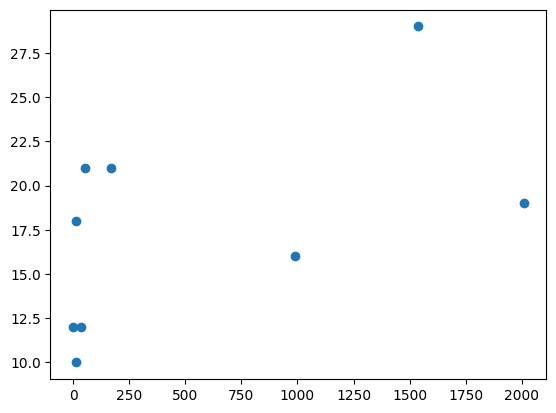

In [25]:
plt.scatter(pr, t_n)

In [26]:
np.mean(t_n)

17.555555555555557

In [27]:
'''average claim size for one disaster'''
one_pr = [int(p) / int(t) for p,t in zip(pr, t_n)]
print(one_pr)
np.mean(one_pr)

[1.4, 53.0, 105.6842105263158, 0.7222222222222222, 2.5714285714285716, 61.8125, 2.9166666666666665, 0.0, 8.095238095238095]


26.24469623131904

2024-05-10 03:53:59.269 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.135324)
2024-05-10 03:53:59.271 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED powerlaw distribution (taking more than 30 seconds)
2024-05-10 03:53:59.273 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.116097)
2024-05-10 03:53:59.305 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.078201)
2024-05-10 03:53:59.340 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.133822)
2024-05-10 03:53:59.343 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.134741)
2024-05-10 03:53:59.399 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.071912)
2024-05-10 03:53:59.420 | INFO     | fitter.fitter:_fit_single_distribution:337

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
pareto,0.065773,1233.067250,1233.658924,inf,0.193434,0.828952
genextreme,0.066618,1230.047355,1230.639028,inf,0.172403,0.912428
gamma,0.071912,1278.255468,1278.847142,inf,0.303956,0.309723
t,0.074453,1395.296436,1395.888110,inf,0.302146,0.316373
chi2,0.076115,1188.641365,1189.233039,inf,0.249065,0.551578


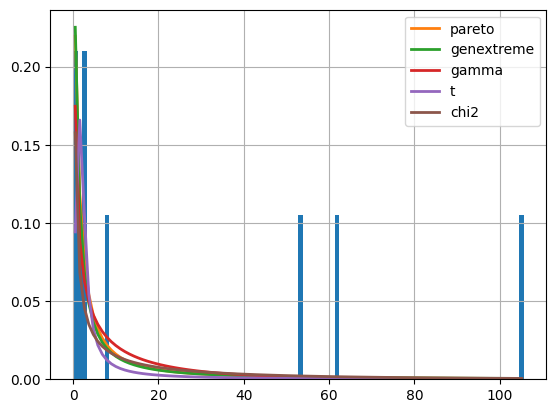

In [28]:
from fitter import Fitter, get_common_distributions


#Organize Data - from question
SR_y = pd.Series(one_pr, name="one_pr (Target Vector Distribution)")


# fitter
distributions_set = get_common_distributions()
distributions_set.extend(['arcsine', 'cosine', 'expon', 'weibull_max', 'weibull_min', 
                          'dweibull', 't', 'pareto', 'exponnorm', 'lognorm',
                          "norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"])  

f = Fitter(SR_y, distributions = distributions_set) 
f.fit()
f.summary()

In [45]:
df = pd.DataFrame( {'distributions': distributions_set})
df

,distributions
0,cauchy
1,chi2
2,expon
3,exponpow
4,gamma
5,lognorm
6,norm
7,powerlaw
8,rayleigh
9,uniform


In [43]:
f.fitted_param

{'expon': (0.0, 26.24469623131904),
 'norm': (26.24469623131904, 36.029331357245894),
 'cauchy': (1.950000333388905, 2.801292800690641),
 'rayleigh': (-27.625262801848002, 45.8262217746855),
 'uniform': (0.0, 105.6842105263158),
 'gamma': (0.42071020075815735, -3.243621075948758e-27, 24.625934346833013),
 'cosine': (32.74874704328465, 31.461391785211116),
 'exponpow': (0.4943805754688193, -4.4195186890492905e-27, 71.96859030388885),
 'arcsine': (-10.410532399487096, 116.0947429258029),
 'chi2': (0.5113156103095793, -2.3164075151817982e-24, 30.28300305825474),
 'lognorm': (6.132926030898442, -2.2917319712832668e-18, 0.0495028101867578),
 'pareto': (0.5642169992796822, -1.6743866523778852, 1.674386652377885),
 'weibull_max': (0.19318145414714671, 105.68421052631581, 1.561761302517819),
 'dweibull': (2.661472797687799, 36.729891949752364, 39.35503876253301),
 'weibull_min': (0.519485696275729,
  -1.8144554711696923e-27,
  37.07334980699179),
 't': (0.4486140777676948, 1.6768139430968971, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


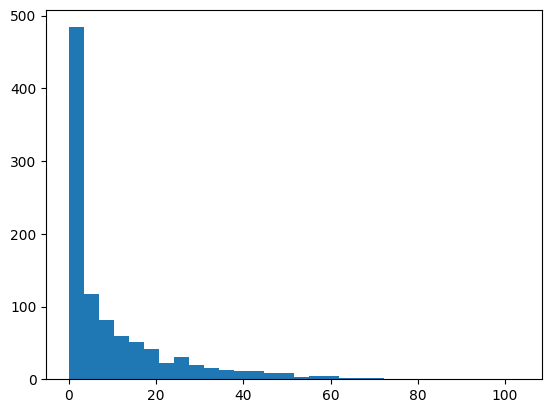

In [31]:
from scipy.stats import gamma

r = gamma.rvs(0.42071020075815735, -3.243621075948758e-27, 24.625934346833013, size =1000)

abs_r = []

for i in r:
    if i >= 0:
        abs_r.append(i)
    if i < 0:
        abs_r.append(0)
        
plt.hist(abs_r, bins=30, histtype="stepfilled")
#plt.set_xlim([x[0], x[-1]])
plt.legend(loc='best', frameon=False)
plt.show()

((array([-3.19758950e+00, -2.93237785e+00, -2.78437841e+00, -2.67999560e+00,
         -2.59855946e+00, -2.53139899e+00, -2.47402263e+00, -2.42379214e+00,
         -2.37902149e+00, -2.33856546e+00, -2.30160949e+00, -2.26755284e+00,
         -2.23593934e+00, -2.20641415e+00, -2.17869564e+00, -2.15255643e+00,
         -2.12781017e+00, -2.10430217e+00, -2.08190261e+00, -2.06050135e+00,
         -2.04000420e+00, -2.02032992e+00, -2.00140792e+00, -1.98317650e+00,
         -1.96558137e+00, -1.94857451e+00, -1.93211325e+00, -1.91615948e+00,
         -1.90067901e+00, -1.88564107e+00, -1.87101783e+00, -1.85678408e+00,
         -1.84291686e+00, -1.82939524e+00, -1.81620005e+00, -1.80331371e+00,
         -1.79072004e+00, -1.77840415e+00, -1.76635224e+00, -1.75455157e+00,
         -1.74299028e+00, -1.73165738e+00, -1.72054262e+00, -1.70963644e+00,
         -1.69892989e+00, -1.68841463e+00, -1.67808281e+00, -1.66792707e+00,
         -1.65794051e+00, -1.64811661e+00, -1.63844924e+00, -1.62893261e+00,

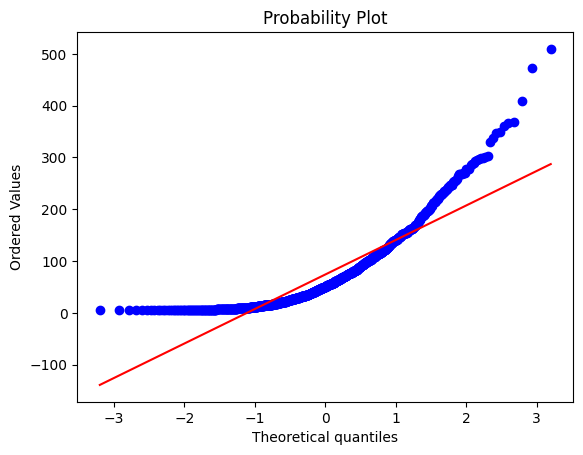

In [15]:
stats.probplot(abs_r, plot=plt)

In [32]:
claims = {}
for t in tqdm(years):
    claims_t = []
    for i in range(10000):
        rvs = poisson.rvs(17.555555555555557*t)*gamma.rvs(0.42071020075815735, -3.243621075948758e-27, 24.625934346833013)
        if rvs >= 0:
            claims_t.append(rvs)
        if rvs < 0:
            claims_t.append(0)
        claims[f'X_{t}'] = claims_t

100%|███████████████████████████████████████████| 61/61 [00:29<00:00,  2.05it/s]


In [33]:
sorted_claims = {k: sorted(v) for k, v in claims.items()}

In [34]:
cdf_all = pd.DataFrame(sorted_claims)
cdf_all

,X_0.0,X_0.08333333333333333,X_0.16666666666666666,X_0.25,X_0.3333333333333333,X_0.4166666666666667,X_0.5,X_0.5833333333333334,X_0.6666666666666666,X_0.75,...,X_4.25,X_4.333333333333333,X_4.416666666666667,X_4.5,X_4.583333333333333,X_4.666666666666667,X_4.75,X_4.833333333333333,X_4.916666666666667,X_5.0
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,7.470908e-07,7.876234e-08,...,7.232143e-07,2.479296e-07,3.144325e-07,3.328254e-08,0.000002,4.382985e-07,0.000003,7.633792e-09,6.673498e-08,3.162270e-07
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,5.645993e-08,1.472597e-06,5.200556e-07,...,8.602546e-07,3.776260e-06,1.281605e-06,4.001045e-08,0.000004,8.061595e-07,0.000004,5.448265e-08,7.038266e-07,2.342157e-06
2,0.0,0.000000,0.000000,0.000000,0.000000,7.189477e-11,0.000000e+00,2.209331e-06,4.401707e-06,9.858991e-07,...,8.869766e-07,4.239081e-06,1.810827e-06,1.097315e-06,0.000005,1.160099e-06,0.000004,1.711572e-07,8.737452e-07,3.348480e-06
3,0.0,0.000000,0.000000,0.000000,0.000000,2.357175e-08,2.367232e-07,2.293527e-06,4.728008e-06,1.715628e-06,...,3.944920e-06,5.570938e-06,5.428115e-06,1.221868e-06,0.000009,1.746368e-06,0.000049,1.998318e-06,9.530068e-07,1.283449e-05
4,0.0,0.000000,0.000000,0.000000,0.000000,6.841419e-08,7.418861e-07,2.322177e-06,8.013189e-06,2.936772e-06,...,9.578463e-06,1.376348e-05,6.703171e-06,2.596271e-06,0.000009,5.257341e-06,0.000063,4.934022e-06,1.625870e-06,2.897371e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,479.715014,611.968756,934.647148,1035.526024,1.350282e+03,1.889422e+03,1.765413e+03,2.244005e+03,2.375263e+03,...,1.154301e+04,1.098642e+04,1.028862e+04,1.309061e+04,12386.120335,1.157055e+04,12105.686509,1.151848e+04,1.339501e+04,1.467375e+04
9996,0.0,483.830205,622.320367,960.442490,1096.279639,1.380055e+03,2.006656e+03,1.894830e+03,2.478929e+03,2.732948e+03,...,1.155830e+04,1.228711e+04,1.043883e+04,1.468739e+04,12609.903425,1.181418e+04,13153.857542,1.241431e+04,1.411410e+04,1.486201e+04
9997,0.0,519.909314,653.231229,1027.714134,1151.033827,1.522659e+03,2.205789e+03,1.953469e+03,2.606655e+03,2.798874e+03,...,1.161810e+04,1.255283e+04,1.057300e+04,1.671351e+04,12688.084639,1.193836e+04,13420.287998,1.273950e+04,1.485134e+04,1.560187e+04
9998,0.0,527.489667,781.515071,1047.225661,1164.468326,1.614908e+03,2.537209e+03,1.989388e+03,2.670055e+03,2.869706e+03,...,1.219674e+04,1.310235e+04,1.062417e+04,1.758708e+04,13309.198008,1.246435e+04,14018.533322,1.347690e+04,1.583365e+04,1.865188e+04


In [35]:
def integrand(x):
    return a

prob = []

for i in range(1,10001):
    prob.append(i/10000)

for i in years:
    cdf_all[f'prob_{i}'] = prob
    
for i in years:
    cdf_all[f'prob_{i}'][(cdf_all[f'X_{i}']==0)] = 0

n= -1
for i in years:
    n+=1
    cdf_all[f'rate_{i}'] = rate[n]

n= -1
for i in years:
    n+=1
    a = rate[n]
    cdf_all[f'discount_{i}'] = math.exp(-quad(integrand, 0, i)[0])

for i in years:
    cdf_all[f'V_{i}'] = cdf_all[f'discount_{i}']*cdf_all[f'prob_{i}']

/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_98824/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_98824/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_98824/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [36]:
X_0 = []
Y_0 = []
Z_0 = []

for i in years:
    for n in cdf_all[f'X_{i}'].tolist():
        X_0.append(n)

for i in years:
    for n in cdf_all[f'V_{i}'].tolist():
        Y_0.append(n)

for i in years:
    for n in range(10000):
        Z_0.append(i)


X = X_0
Y = Y_0
Z = Z_0

plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),np.linspace(np.min(Y),np.max(Y),10))
plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')


@interact(elev=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False), azim=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False))
def plot_3d(elev, azim):
    #Figure settings
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111, projection='3d')
    #Display 3D graph
    ax.plot_surface(plotx,plotz,ploty,cstride=1,rstride=1,cmap='viridis')
    ax.set_xlabel('D (критический уровень триггера)') 
    ax.set_ylabel('T (срок, лет)') 
    ax.set_zlabel('V (Стоимость) ')
    
    #Set the initial value of the viewing direction of the 3D graph
    ax.view_init(elev=elev, azim=azim)
    plt.show()

interactive(children=(IntSlider(value=30, continuous_update=False, description='elev', max=180, min=-180, step…

In [37]:
# Expected loss 2%
s_2 = round(((1/cdf_all['V_2.0'][9800])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9800])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9800])**(1/4)-1-0.1192)*100, 3)

print('Expected loss 2%')
print(round(cdf_all['X_2.0'][9800], 3), round(cdf_all['X_3.0'][9800], 3), round(cdf_all['X_4.0'][9800], 3))
print(round(cdf_all['V_2.0'][9800], 4), round(cdf_all['V_3.0'][9800], 4), round(cdf_all['V_4.0'][9800], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 2,5%
s_2 = round(((1/cdf_all['V_2.0'][9750])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9750])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9750])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 2,5%')
print(round(cdf_all['X_2.0'][9750], 3), round(cdf_all['X_3.0'][9750], 3), round(cdf_all['X_4.0'][9750], 3))
print(round(cdf_all['V_2.0'][9750], 4), round(cdf_all['V_3.0'][9750], 4), round(cdf_all['V_4.0'][9750], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 3%
s_2 = round(((1/cdf_all['V_2.0'][9700])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9700])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9700])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 3%')
print(round(cdf_all['X_2.0'][9700], 3), round(cdf_all['X_3.0'][9700], 3), round(cdf_all['X_4.0'][9700], 3))
print(round(cdf_all['V_2.0'][9700], 4), round(cdf_all['V_3.0'][9700], 4), round(cdf_all['V_4.0'][9700], 4))
print(s_2, s_3, s_4)

Expected loss 2%
2190.225 3207.708 4269.594
0.7581 0.6672 0.5875
2.301 2.28 2.301

Expected loss 2,5%
2021.587 2926.193 3881.994
0.7542 0.6638 0.5845
2.595 2.475 2.447

Expected loss 3%
1887.967 2723.335 3592.959
0.7504 0.6604 0.5815
2.891 2.672 2.594
